In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
file_path = "C:/Users/ahosain/Downloads/Housing.csv"
housing_data = pd.read_csv(file_path)

In [3]:
# Convert categorical variables to numerical values
categorical_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"]
for col in categorical_columns:
    housing_data[col] = housing_data[col].astype("category").cat.codes


In [4]:
# Define feature columns and target column
X = housing_data.drop(columns=["price"]).values.astype(np.float32)
y = housing_data["price"].values.astype(np.float32)

In [5]:
# Split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64, 32], output_size=1):
        
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)  
        return x

# Initialize model
input_size = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPRegressor(input_size).to(device)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Move data to the same device as the model
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_val_tensor, y_val_tensor = X_val_tensor.to(device), y_val_tensor.to(device)

In [9]:
# Training loop
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 0/100, Train Loss: 25234849660928.0000, Val Loss: 30129612914688.0000
Epoch 10/100, Train Loss: 25206970122240.0000, Val Loss: 30090373103616.0000
Epoch 20/100, Train Loss: 24852683554816.0000, Val Loss: 29627034632192.0000
Epoch 30/100, Train Loss: 22639676489728.0000, Val Loss: 26738071437312.0000
Epoch 40/100, Train Loss: 13756883009536.0000, Val Loss: 15624461877248.0000
Epoch 50/100, Train Loss: 4939463524352.0000, Val Loss: 4063512756224.0000
Epoch 60/100, Train Loss: 4556008718336.0000, Val Loss: 4836190322688.0000
Epoch 70/100, Train Loss: 4930989457408.0000, Val Loss: 5122093481984.0000
Epoch 80/100, Train Loss: 4161614905344.0000, Val Loss: 3971399548928.0000
Epoch 90/100, Train Loss: 4751269298176.0000, Val Loss: 4415612256256.0000


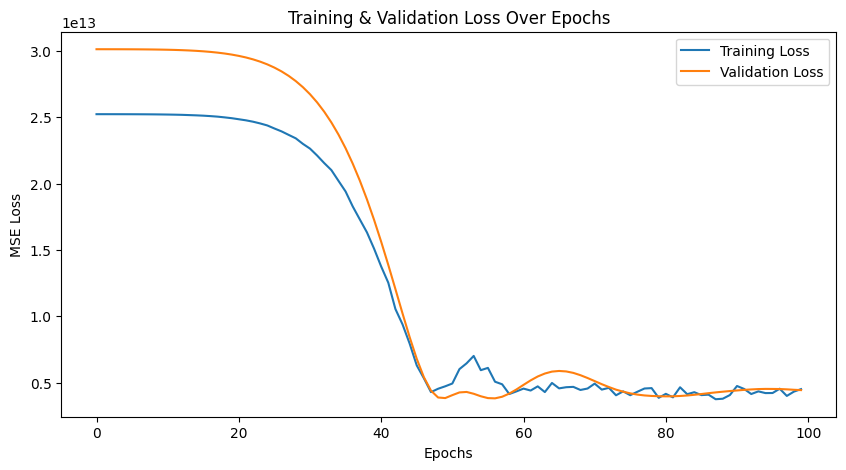

In [10]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()


In [11]:
# Final Model Accuracy (R-Squared)
model.eval()
with torch.no_grad():
    final_predictions = model(X_val_tensor).cpu().numpy().flatten()
r2 = r2_score(y_val, final_predictions)

print(f"\nFinal Model Accuracy (R² Score): {r2:.4f}")
print(f"Model Complexity (Total Trainable Parameters): {sum(p.numel() for p in model.parameters())}")


Final Model Accuracy (R² Score): 0.1211
Model Complexity (Total Trainable Parameters): 181249
